# Proyek Klasifikasi Gambar: [Dataset Jenis Kucing]
- **Nama:** Muhammad Azmi Alauddin
- **Email:** mc227d5y1203@student.devacademy.id
- **ID Dicoding:** MC227D5Y1203

## Import Semua Packages/Library yang Digunakan

In [ ]:
# Library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

In [ ]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

## Data Preparation

### Data Loading

In [ ]:
# Import module yang disediakan google colab untuk kebutuhan upload file

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muhammadzmi","key":"703dd402938a628c015dc5c7f4550435"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download the dataset from Kaggle
!kaggle datasets download -d mibrahimhanif/jenis-kucing
!unzip jenis-kucing.zip

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: train val/Belang Tiga/a9fa38e17a4ed0084f20fb7065133600_0_820.jpeg  
  inflating: train val/Belang Tiga/a9fa38e17a4ed0084f20fb7065133600_0_9573.jpeg  
  inflating: train val/Belang Tiga/aa2ce8aaa83640e62cdb244b9ad79d7f_0_3001.jpeg  
  inflating: train val/Belang Tiga/aa2ce8aaa83640e62cdb244b9ad79d7f_0_5822.jpeg  
  inflating: train val/Belang Tiga/aa2ce8aaa83640e62cdb244b9ad79d7f_0_7110.jpeg  
  inflating: train val/Belang Tiga/aa2ce8aaa83640e62cdb244b9ad79d7f_0_7417.jpeg  
  inflating: train val/Belang Tiga/aa2ce8aaa83640e62cdb244b9ad79d7f_0_7982.jpeg  
  inflating: train val/Belang Tiga/aa75dc5c22a4f533baa6f8f6da1dfcc8_0_4289.jpeg  
  inflating: train val/Belang Tiga/aa75dc5c22a4f533baa6f8f6da1dfcc8_0_4874.jpeg  
  inflating: train val/Belang Tiga/aa75dc5c22a4f533baa6f8f6da1dfcc8_0_8105.jpeg  
  inflating: train val/Belang Tiga/aa75dc5c22a4f533baa6f8f6da1dfcc8_0_8827.jpeg  
  inflating: train val/Belang Tiga/aa75d

### Data Preprocessing

In [ ]:
import os
import shutil

In [ ]:
# Membagi file ke folder train dan test
base_dir = './train val'  # Path ke direktori dataset asli
train_dir = os.path.join(base_dir, 'train')  # Path ke direktori train
test_dir = os.path.join(base_dir, 'test')  # Path ke direktori test

In [ ]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

In [ ]:
classes = ['Belang Tiga', 'Hitam']

In [ ]:
for cls in classes:
    # Path ke folder kelas dalam dataset asli
    cls_dir = os.path.join(base_dir, cls)

    # Dapatkan semua file gambar dalam folder kelas
    images = os.listdir(cls_dir)

    # Bagi data menjadi train dan test
    train_size = int(0.8 * len(images))  # 80% untuk train
    train_images = images[:train_size]
    test_images = images[train_size:]

    # Salin file gambar ke folder train dan test yang sesuai
    for img in train_images:
        src = os.path.join(cls_dir, img)
        dst = os.path.join(train_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)  # Buat folder kelas di train_dir jika belum ada
        shutil.copyfile(src, dst)

    for img in test_images:
        src = os.path.join(cls_dir, img)
        dst = os.path.join(test_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)  # Buat folder kelas di test_dir jika belum ada
        shutil.copyfile(src, dst)

In [ ]:
# Direktori awal untuk train dan test
train_dir = "./train val/train"
test_dir = "./train val/test"

# Direktori baru untuk dataset gabungan
combined_dir = "./train val/dataset"

In [ ]:
# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

In [ ]:
# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

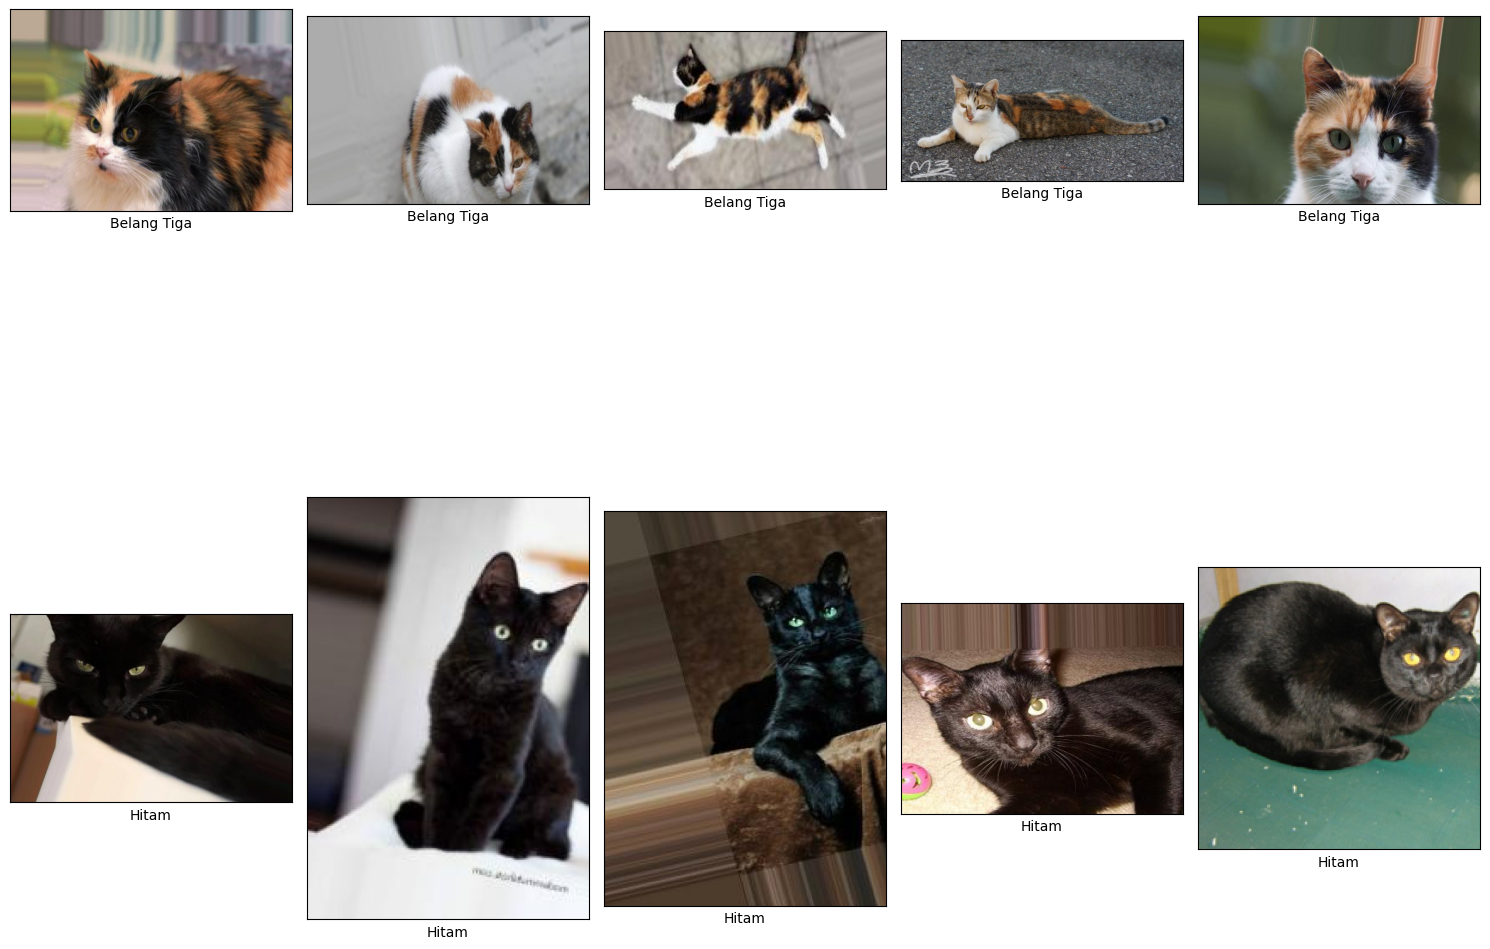

In [ ]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
lung_image = {}

# Tentukan path sumber train
path = "./train val/"
path_sub = os.path.join(path, "dataset")
for i in os.listdir(path_sub):
    lung_image[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan secara acak 5 gambar di bawah setiap dari 2 kelas dari data.
# Anda akan melihat gambar yang berbeda setiap kali kode ini dijalankan.
path_sub = "./train val/dataset/"

import matplotlib.pyplot as plt
# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(lung_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(lung_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

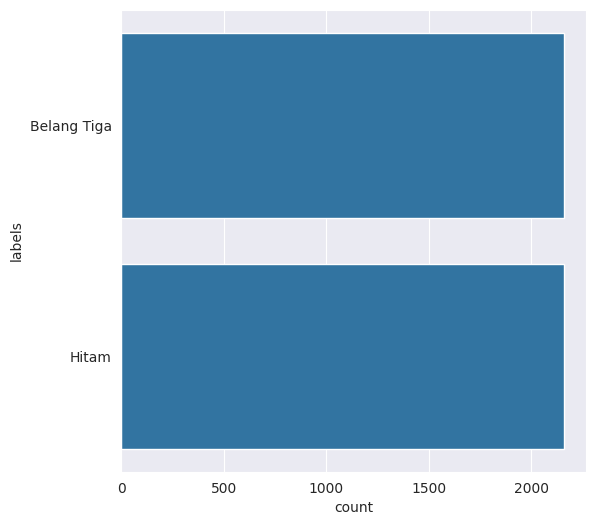

In [ ]:
import seaborn as sns
# Definisikan path sumber
lung_path = "./train val/dataset/"

# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

#### Split Dataset

In [ ]:
df = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})
# Variabel yang digunakan pada pemisahan data ini di mana variabel x = data path dan y = data labels
X= df['path']
y= df['labels']

# Split dataset awal menjadi data train dan test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2, random_state=300)

In [ ]:
# Jumlah data train, val, dan test
print(f'Jumlah data train X: {len(X_train)}')
print(f'Jumlah data val X: {len(X_val)}')
print(f'Jumlah data test X: {len(X_test)}')

Jumlah data train X: 2764
Jumlah data val X: 692
Jumlah data test X: 864


In [ ]:
# Direktori untuk data train
train_dir = './train val/train'
os.makedirs(train_dir, exist_ok=True)

In [ ]:
for x, y in zip(X_train, y_train):
    label_dir = os.path.join(train_dir, y)
    os.makedirs(label_dir, exist_ok=True)

    # Asumsikan x adalah path ke file
    shutil.copy(x, os.path.join(label_dir, os.path.basename(x)))

In [ ]:
# Jumlah data setiap label di folder data train
for label in os.listdir(train_dir):
  label_dir = os.path.join(train_dir, label)
  print(f'Jumlah data {label}: {len(os.listdir(label_dir))}')

Jumlah data Belang Tiga: 1998
Jumlah data Hitam: 2002


#### Data Augmentasi

In [ ]:
# Membuat fungsi untuk melakukan rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, sudut)

# Membuat fungsi untuk melakukan rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    sudut = random.randint(0,180)
    return rotate(img, -sudut)

# Membuat fungsi untuk membalik gambar secara vertikal dari atas ke bawah
#def flip_up_down(img):
    #img = cv2.cvtColor(img, 0)
    #img = cv2.resize(img, (224,224))
    #return np.flipud(img)

# Membuat fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    img = adjust_gamma(img, gamma=0.5,gain=1)
    return img

# Membuat fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    return cv2.GaussianBlur(img, (9,9),0)

# Membuat fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode="wrap")
    return shear_image

# Membuat fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, 0)
    img = cv2.resize(img, (224,224))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

In [ ]:
# Membuat variabel transformasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'warp shift': warp_shift,
    'blurring image': blur_image,
    'add brightness': add_brightness,
    #'flip up down': flip_up_down,
    'shear image': sheared
}

# Path ke dataset Batik Anda
dataset_path = "./train val/dataset"  # Path ke folder dataset utama
augmented_data_path = "./train val/augmented_dataset" # Path ke folder dataset yang telah diaugmentasi

# Buat folder dataset yang telah diaugmentasi
os.makedirs(augmented_data_path, exist_ok=True)

# Loop melalui setiap folder kelas dalam dataset
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    # Buat folder yang sesuai di dataset yang telah diaugmentasi
    augmented_class_path = os.path.join(augmented_data_path, class_name)
    os.makedirs(augmented_class_path, exist_ok=True)

    # Dapatkan semua path gambar dalam folder kelas
    images = [os.path.join(class_path, im) for im in os.listdir(class_path)]

    # Jumlah gambar yang diaugmentasi yang akan dihasilkan per kelas
    images_to_generate = 3000
    i = 1

    while i <= images_to_generate:
        image = random.choice(images)
        try:
            # Membaca gambar menggunakan OpenCV
            original_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE) # Membaca dalam skala keabuan agar sesuai dengan fungsi transformasi

            # Memilih transformasi secara acak
            transformation_type = random.choice(list(transformations))

            # Menerapkan transformasi
            transformed_image = transformations[transformation_type](original_image) # Menetapkan nilai ke transformed_image

            new_image_path = "%s/augmented_image_%s.jpg" % (augmented_class_path, i)
            transformed_image = img_as_ubyte(transformed_image)
            cv2.imwrite(new_image_path, transformed_image)
            i = i + 1
        except ValueError as e:
            print('tidak dapat membaca', image, ':', e, 'karenanya dilewati.')

In [ ]:
# Menambahkan data train hasil augmentasi ke folder dataset train
for label in os.listdir(train_dir):
    aug_label_dir = os.path.join(augmented_data_path, label)
    target_label_dir = os.path.join(train_dir, label)
    os.makedirs(target_label_dir, exist_ok=True)

    if os.path.exists(aug_label_dir):
        for fname in os.listdir(aug_label_dir):
            src_file = os.path.join(aug_label_dir, fname)
            dst_file = os.path.join(target_label_dir, fname)
            shutil.copy(src_file, dst_file)

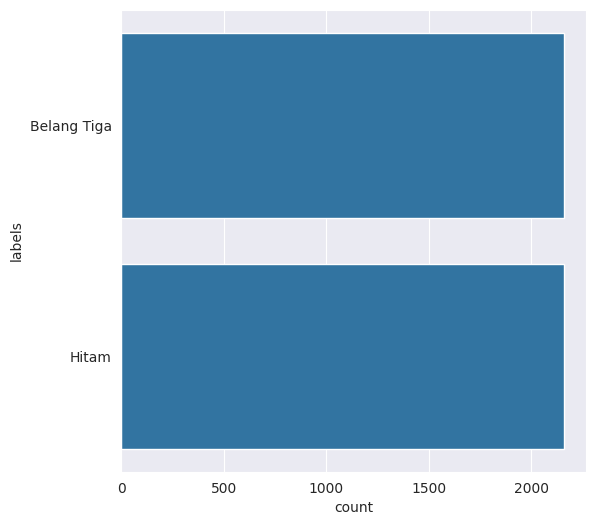

In [ ]:
# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [ ]:
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Belang Tiga,2160
Hitam,2160


In [ ]:
# Menyatukan ke dalam masing-masing dataframe
X_train2 = []
y_train2 = []

for label in os.listdir(train_dir):
  label_dir = os.path.join(train_dir, label)
  for fname in os.listdir(label_dir):
    X_train2.append(os.path.join(label_dir, fname))
    y_train2.append(label)

df_tr = pd.DataFrame({'path':X_train2,'labels':y_train2,'set':'train'})
df_val = pd.DataFrame({'path':X_val,'labels':y_val,'set':'val'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sampel data
print(df_all.sample(5))


set    labels     
test   Belang Tiga     462
       Hitam           402
train  Belang Tiga    4998
       Hitam          5002
val    Belang Tiga     336
       Hitam           356
dtype: int64 


                                                    path       labels    set
5385   ./train val/train/Hitam/f72f109b4d17a9e1a24678...        Hitam  train
9178   ./train val/train/Hitam/Bombay-cat-breed-perso...        Hitam  train
11237  ./train val/dataset/Hitam/9d09159619f63885fb6a...        Hitam    val
8941   ./train val/train/Hitam/60fef232441f56629ad745...        Hitam  train
4155   ./train val/train/Belang Tiga/2e56a8ab4beca32c...  Belang Tiga  train


In [ ]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "./train val/dataset/"
# Membuat variabel Dataset, tempat menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "Dataset-Final/"

for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

####Image Data Generator

In [ ]:
# Definisikan direktori training dan test
TRAIN_DIR = "Dataset-Final/train/"
TEST_DIR = "Dataset-Final/test/"

train_belang = os.path.join(TRAIN_DIR + '/Belang Tiga')
train_hitam = os.path.join(TRAIN_DIR + '/Hitam')

test_belang = os.path.join(TEST_DIR + '/Belang Tiga')
test_hitam = os.path.join(TEST_DIR + '/Hitam')

print("Total number of belang images in training set: ",len(os.listdir(train_belang)))
print("Total number of hitam images in training set: ",len(os.listdir(train_hitam)))

print("Total number of belang images in test set: ",len(os.listdir(test_belang)))
print("Total number of hitam images in test set: ",len(os.listdir(test_hitam)))

Total number of belang images in training set:  4998
Total number of hitam images in training set:  5002
Total number of belang images in test set:  462
Total number of hitam images in test set:  402


In [ ]:
# Buat objek ImageDataGenerator yang menormalkan gambar
datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split = 0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = datagen.flow_from_directory(TRAIN_DIR,
                                              batch_size=32,
                                              target_size=(224,224),
                                              color_mode="rgb",
                                              class_mode='categorical',
                                              subset='training',
                                              shuffle=True)

validation_generator = datagen.flow_from_directory(TRAIN_DIR,
                                                   batch_size=32,
                                                   target_size=(224,224),
                                                color_mode="rgb",
                                                   class_mode='categorical',
                                                   subset='validation',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  batch_size=1,
                                                  target_size=(224,224),
                                                  color_mode="rgb",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 8001 images belonging to 2 classes.
Found 1999 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


## Modelling

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Tampilkan ringkasan arsitektur model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    37,749,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,433,858 (146.61 MB)

 Trainable params: 38,433,858 (146.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [34]:
# Latih model
history = model.fit(
    train_generator,
    steps_per_epoch=36,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5456 - loss: 1.4869

36/36 ━━━━━━━━━━━━━━━━━━━━ 348s 10s/step - accuracy: 0.5481 - loss: 1.4707 - val_accuracy: 0.7369 - val_loss: 0.5474
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7941 - loss: 0.4514

36/36 ━━━━━━━━━━━━━━━━━━━━ 333s 9s/step - accuracy: 0.7941 - loss: 0.4516 - val_accuracy: 0.8584 - val_loss: 0.3608
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 333s 9s/step - accuracy: 0.8241 - loss: 0.4214 - val_accuracy: 0.8474 - val_loss: 0.3707
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8620 - loss: 0.3781

36/36 ━━━━━━━━━━━━━━━━━━━━ 345s 10s/step - accuracy: 0.8613 - loss: 0.3789 - val_accuracy: 0.8559 - val_loss: 0.3582
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8709 - loss: 0.3395

36/36 ━━━━━━━━━━━━━━━━━━━━ 336s 9s/step - accuracy: 0.8707 - loss: 0.3400 - val_accuracy: 0.9025 - val_loss: 0.2572
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8662 - loss: 0.3250

36/36 ━━━━━━━━━━━━━━━━━━━━ 322s 9s/step - accuracy: 0.8661 - loss: 0.3253 - val_accuracy: 0.9130 - val_loss: 0.2437
Epoch 7/10
35/36 ━━━━━━━━━━━━━━━━━━━━ 5s 6s/step - accuracy: 0.8635 - loss: 0.3426 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 330s 9s/step - accuracy: 0.8635 - loss: 0.3429 - val_accuracy: 0.8999 - val_loss: 0.2410
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8562 - loss: 0.3777

36/36 ━━━━━━━━━━━━━━━━━━━━ 345s 10s/step - accuracy: 0.8564 - loss: 0.3771 - val_accuracy: 0.9115 - val_loss: 0.2355
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8783 - loss: 0.3050

36/36 ━━━━━━━━━━━━━━━━━━━━ 331s 9s/step - accuracy: 0.8782 - loss: 0.3047 - val_accuracy: 0.9295 - val_loss: 0.1938
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 328s 9s/step - accuracy: 0.8682 - loss: 0.3229 - val_accuracy: 0.9145 - val_loss: 0.2058


## Evaluasi dan Visualisasi

In [35]:
# Evaluasi model menggunakan data pengujian
evaluation = model.evaluate(
    test_generator,
    steps=test_generator.samples // test_generator.batch_size
)

# Menampilkan hasil evaluasi
print("Loss:", evaluation[0])
print("Accuracy:", evaluation[1])

864/864 ━━━━━━━━━━━━━━━━━━━━ 59s 68ms/step - accuracy: 0.9625 - loss: 0.0995
Loss: 0.09431715309619904
Accuracy: 0.9652777910232544


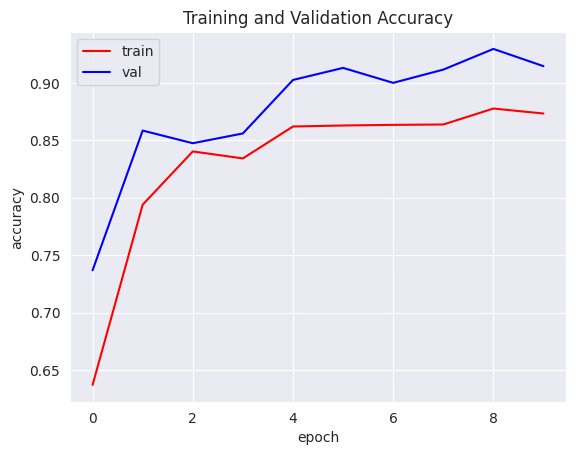

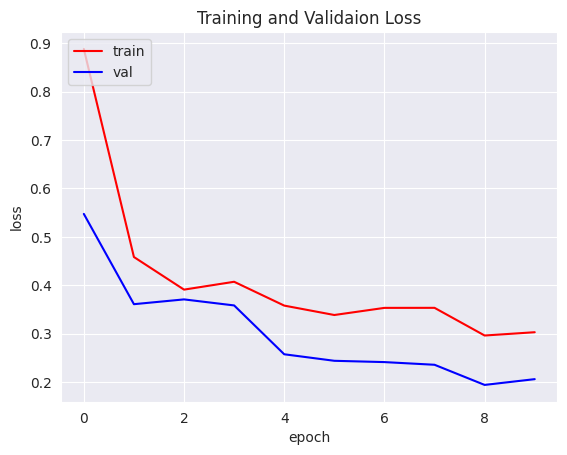

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()



              precision    recall  f1-score   support

 Belang Tiga     0.9821    0.9524    0.9670       462
       Hitam     0.9471    0.9801    0.9633       402

    accuracy                         0.9653       864
   macro avg     0.9646    0.9662    0.9652       864
weighted avg     0.9658    0.9653    0.9653       864



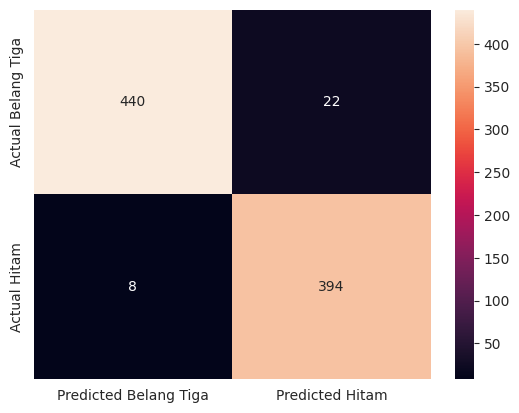

In [38]:
test_generator.reset()

preds_1 = model.predict(test_generator, verbose=0)
# Convert predictions to multiclass format
predicted_labels = np.argmax(preds_1, axis=1)  # Get index of highest probability

# Print Confusion Matrix
cm = pd.DataFrame(data=confusion_matrix(test_generator.classes, predicted_labels, labels=[0, 1]),
                  index=["Actual Belang Tiga", "Actual Hitam"],
                  columns=["Predicted Belang Tiga", "Predicted Hitam"])
sns.heatmap(cm, annot=True, fmt="d")

# Print Classification Report
print("\n")
print(classification_report(y_true=test_generator.classes, y_pred=predicted_labels,
                            target_names=['Belang Tiga', 'Hitam'], digits=4))  # Updated target_names

## Konversi Model

In [40]:
# Konversi model ke TFJS
!pip install tensorflowjs

!tensorflowjs_converter \
  --input_format=keras \
  best_model.h5 \
  modeltfjs/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
2025-05-10 05:21:49.744627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746854509.789486   18307 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:174

In [41]:
# Konversi model ke TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

# Label.txt
with open('labels.txt', 'w') as f:
  for label in labels:
    f.write(label + '\n')

Saved artifact at '/tmp/tmpe76pd0jz'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139873657779984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873708733456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873657780368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873657779408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873657781520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873657780560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873708732688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873657780176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873603174480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873603176208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13987360317601

In [42]:
# Konversi model ke Saved Model
model.export('saved_model/')

Saved artifact at 'saved_model/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139873657779984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873708733456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873657780368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873657779408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873657781520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873657780560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873708732688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873657780176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873603174480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873603176208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139873603176016: T

In [43]:
# Zip folder
!zip -r modeltfjs.zip modeltfjs

# Download zip
from google.colab import files
files.download('modeltfjs.zip')


  adding: modeltfjs/ (stored 0%)
  adding: modeltfjs/group1-shard24of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard28of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard34of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard25of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard33of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard2of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard1of37.bin (deflated 8%)
  adding: modeltfjs/group1-shard31of37.bin (deflated 7%)
  adding: modeltfjs/model.json (deflated 87%)
  adding: modeltfjs/group1-shard22of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard23of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard37of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard4of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard8of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard18of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard11of37.bin (deflated 7%)
  adding: modeltfjs/group1-shard20of37.bin (deflated 7%)
  adding: mod

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# Zip folder
!zip -r saved_model.zip saved_model

# Download zip
from google.colab import files
files.download('saved_model.zip')

  adding: saved_model/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 86%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/variables/variables.index (deflated 64%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Inference (Optional)